# still in experiment phase-  not working

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os, sys, time
import numpy as np
import pandas as pd
sys.path.append('../')
from utils.camera import Camera
import tensorflow as tf
from tensorflow import keras
from IPython.display import display
import ipywidgets.widgets as widgets
# import warnings
#warnings.filterwarnings('ignore')

In [2]:
base_model_class = keras.applications.MobileNetV2
base_model_preprocess_function = keras.applications.mobilenet_v2.preprocess_input

#base_model_class = keras.applications.InceptionV3
#base_model_preprocess_function = keras.applications.inception_v3.preprocess_input

In [3]:
model = keras.models.load_model(f'../models/model_fingers_{base_model_class.__name__}')

In [4]:
# preprocess
def preprocess_image(img):
    start_time= time.time()
    img = img.resize(tuple(model.input.shape)[1:3])
    img_array = np. array(img)
    img_array = img_array.reshape(1, model.input.shape[1], model.input.shape[2], model.input.shape[3])
    img_array = base_model_preprocess_function(img_array)
    duration = time.time() - start_time
    return img_array, duration  

In [5]:
# predict
def predict_from_image_array(img_array):
    start_time= time.time()
    pred_proba = model.predict(img_array)
    duration = time.time() - start_time
    return pd.DataFrame({
        'label' : [labels[i] for i in labels.keys()],
        'proba' : list(pred_proba[0])}), duration

In [6]:
labels = {i: str(i) for i in range(6)}

# initialize camera

In [14]:
# usb camera '/dev/video2'
camera = Camera(capture_device=2, width=224, height=224, 
                     capture_width=2304, capture_height=1536, capture_fps=2, flip_mode=1, debug=True, 
                     is_internal_camera=False)

v4l2src device=/dev/video2 ! video/x-raw, width=(int)2304, height=(int)1536, framerate=(fraction)2/1                     ! videoconvert !  video/x-raw, format=(string)BGR ! appsink drop=true sync=false


# calibrate preprocessing
the net was trained with photos linke this

In [95]:
def calibrate_photo(img):
    lower = np.array([hue_min_widget.value, sat_min_widget.value, val_min_widget.value])
    upper = np.array([hue_max_widget.value, sat_max_widget.value, val_max_widget.value])
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_hsv, lower, upper)
    img_result = cv2.bitwise_and(img, img, mask=mask)
    img_result = cv2.cvtColor(img_result, cv2.COLOR_BGR2GRAY)
    return img_result

In [101]:
def on_change(b):
    global img
    # button pressed for new photo
    try :
        if b.description == 'new photo':
            img = camera.get_image_bgr()
    except:
        pass
    
    image_widget.value = bytes(cv2.imencode('.jpg', calibrate_photo(img))[1])

In [102]:
sample_image_widget = widgets.Image(format='jpeg', width=224, height=224)
image_widget = widgets.Image(format='jpeg', width=224, height=224)
hue_min_widget = widgets.IntSlider(min=0, max=255, value=0  , description='hue_min')
hue_max_widget = widgets.IntSlider(min=0, max=255, value=200, description='hue_max')
sat_min_widget = widgets.IntSlider(min=0, max=255, value=20  , description='sat_min')
sat_max_widget = widgets.IntSlider(min=0, max=255, value=200, description='sat_max')
val_min_widget = widgets.IntSlider(min=0, max=255, value=4  , description='val_min')
val_max_widget = widgets.IntSlider(min=0, max=255, value=200, description='val_max')
new_photo_widget = widgets.Button(value='take new photo', description='new photo')

hue_min_widget.observe(on_change)
hue_max_widget.observe(on_change)
sat_min_widget.observe(on_change)
sat_max_widget.observe(on_change)
val_min_widget.observe(on_change)
val_max_widget.observe(on_change)
new_photo_widget.on_click(on_change)

sample_image_widget.value = bytes(cv2.imencode('.jpg', cv2.imread('../images/finger_3.png'))[1])

In [103]:
display("left is tranilng like image. right a pictiure fom camera. Please adjust", widgets.HBox([sample_image_widget, 
                      widgets.VBox([new_photo_widget,
                                    hue_min_widget, 
                                    hue_max_widget,
                                    sat_min_widget, 
                                    sat_max_widget,
                                    val_min_widget, 
                                    val_max_widget]),image_widget ]))


#sample_img = cv2.imread('../images/finger_3.png')
#show_image(sample_img)

img = camera.get_image_bgr()
on_change(None)

'left is tranilng like image. right a pictiure fom camera. Please adjust'

## predict from camera

4 - time preprocess / prediction:0.00s / 0.30s


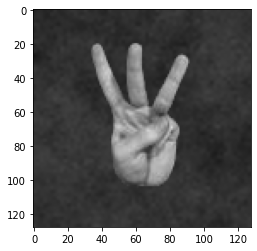

In [119]:
#img = camera.get_image_bgr()
img = cv2.imread('../images/finger_3.png')
#img = calibrate_photo(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img_array, duration_preprocess = preprocess_image(Image.fromarray(img, 'RGB'))
df, duration_predict = predict_from_image_array(img_array)
df
pred_label = df.nlargest(1, 'proba')[['label','proba']].values[0][0]
pred_proba = df.nlargest(1, 'proba')[['label','proba']].values[0][1]
print(f'{pred_label} - time preprocess / prediction:{duration_preprocess:0.2f}s / {duration_predict:0.2f}s')
#plt.imshow(img_array.reshape(128, 128, 3))

## live camera

In [38]:
duration = 30 # running time in seconds

from IPython.display import display
import ipywidgets.widgets as widgets
image_widget = widgets.Image(format='jpeg', width=300, height=300)
label_widget = widgets.Text(description='detected')
confidence_widget = widgets.Text(description='confidence')
time_widget = widgets.Text(description='pred. time')
progress_widget = widgets.FloatProgress(value=0, min=0.0, max=float(duration), description='running time')

display(widgets.HBox([image_widget, 
                      widgets.VBox([label_widget, confidence_widget, time_widget, progress_widget])]))

start_time = time.time()
while time.time() - start_time < duration:
    img_rgb = camera0.get_image_rgb()
    img = Image.fromarray(img_rgb, 'RGB')
    img_array, duration_preprocess = preprocess_image(img)
    df, duration_predict = predict_from_image_array(img_array)
    pred_label = df.nlargest(1, 'proba')[['label','proba']].values[0][0].split(',')[0]
    pred_proba = df.nlargest(1, 'proba')[['label','proba']].values[0][1]
    label_widget.value = pred_label
    confidence_widget.value = f'{pred_proba *100:0.0f} %'
    time_widget.value = f'{duration_predict:0.2f} sec'
    image_widget.value = bytes(cv2.imencode('.jpg', img_rgb)[1])
    progress_widget.value = (time.time() - start_time)

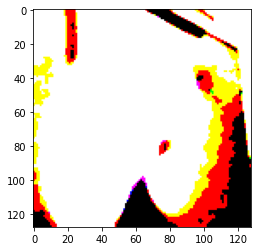

In [70]:
img = camera0.get_image_rgb()
#img = Image.fromarray(img_rgb, 'RGB')
img = cv2.resize(img, (128, 128))
img = cv2.GaussianBlur(img,(5,5),0)
_,img = cv2.threshold(img,80,255,cv2.THRESH_BINARY)
im_floodfill = img.copy()
#h, w = img.shape[:2]
#mask = np.zeros((h+2, w+2), np.uint8)
#cv2.floodFill(im_floodfill, mask, (0,0), 255)
#im_floodfill_inv = cv2.bitwise_not(im_floodfill)
#img = img | im_floodfill_inv


#img = img/255

# plt.imshow(img_array.reshape(128, 128, 3))
plt.imshow(img)
